# 第一次课后作业

## 导入并且加载数据

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats
import numpy as np
import torch.nn as nn

df = pd.read_csv('winequality-red.csv', sep=';')
tensor_data = torch.tensor(df.values, dtype=torch.float32)
print(tensor_data)

tensor([[ 7.4000,  0.7000,  0.0000,  ...,  0.5600,  9.4000,  5.0000],
        [ 7.8000,  0.8800,  0.0000,  ...,  0.6800,  9.8000,  5.0000],
        [ 7.8000,  0.7600,  0.0400,  ...,  0.6500,  9.8000,  5.0000],
        ...,
        [ 6.3000,  0.5100,  0.1300,  ...,  0.7500, 11.0000,  6.0000],
        [ 5.9000,  0.6450,  0.1200,  ...,  0.7100, 10.2000,  5.0000],
        [ 6.0000,  0.3100,  0.4700,  ...,  0.6600, 11.0000,  6.0000]])


## 手工特征工程 + 二值化

In [2]:
list_tensor = []
for i in tensor_data:
    l = []
    if i[0] > 7.0 and i[0] < 10.5:
        l.append(1)
    else:
        l.append(0)
    if i[1] <= 0.6:
        l.append(1)
    else:
        l.append(0)
    if i[2] >= 0.2:
        l.append(1)
    else:
        l.append(0)
    if i[3] > 1.5 and i[3] < 3.5:
        l.append(1)
    else:
        l.append(0)
    if i[4] <= 0.08:
        l.append(1)
    else:
        l.append(0)
    if i[5] > 10.0 and i[5] < 35.0:
        l.append(1)
    else:
        l.append(0)
    if i[6] > 20.0 and i[6] < 100.0:
        l.append(1)
    else:
        l.append(0)
    if i[7] > 0.995 and i[7] < 0.998:
        l.append(1)
    else:
        l.append(0)
    if i[8] > 3.1 and i[8] < 3.5:
        l.append(1)
    else:
        l.append(0)
    if i[9] >= 0.6:
        l.append(1)
    else:
        l.append(0)
    if i[10] > 0.1:
        l.append(1)
    else:
        l.append(0)
    if i[11] > 5.0:
        l.append(1)
    else:
        l.append(0)
    list_tensor.append(l)
list_tensor = torch.tensor(list_tensor)
print(list_tensor)

tensor([[1, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 1, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 0],
        [0, 1, 1,  ..., 1, 1, 1]])


## 找出构造的布尔特征中，与最终目标变量最相关的

In [3]:
list_tensor = list_tensor.clone().detach().to(dtype=torch.float32)
# 提取特征和目标
X = list_tensor[:, :-1]  # 所有列除了最后一列
y = list_tensor[:, -1]  # 最后一列

# 检查标准差是否为零
X_std = X.std(dim=0)
y_std = y.std()

print("特征的标准差:", X_std)
print("目标的标准差:", y_std)

# 检查数据中是否存在 NaN 或 Inf
print("数据中是否存在 NaN:", torch.isnan(X).any() or torch.isnan(y).any())
print("数据中是否存在 Inf:", torch.isinf(X).any() or torch.isinf(y).any())


# 计算皮尔逊相关系数
def pearson_correlation(X, y):
    # 计算均值
    X_mean = X.mean(dim=0, keepdim=True)
    y_mean = y.mean()

    # 中心化
    X_centered = X - X_mean
    y_centered = y - y_mean

    # 计算标准差
    X_std = X_centered.pow(2).sum(dim=0).sqrt()
    y_std = y_centered.pow(2).sum().sqrt()

    # 跳过标准差为零的特征
    valid_features = X_std != 0
    X_centered = X_centered[:, valid_features]
    X_std = X_std[valid_features]

    # 计算协方差
    covariance = (X_centered * y_centered.unsqueeze(1)).sum(dim=0)

    # 计算相关系数
    correlation = torch.zeros(X.shape[1])  # 初始化相关系数为 0
    correlation[valid_features] = covariance / (X_std * y_std)
    return correlation


# 计算每个特征与目标之间的相关系数
correlations = pearson_correlation(X, y)

# 找到相关系数绝对值最大的特征
best_feature_index = correlations.abs().argmax().item()

print(f"最佳特征索引: {best_feature_index}")
print(f"相关系数: {correlations[best_feature_index].item()}")

特征的标准差: tensor([0.4760, 0.4647, 0.4853, 0.3609, 0.4980, 0.4960, 0.4619, 0.4874, 0.3983,
        0.4918, 0.0000])
目标的标准差: tensor(0.4989)
数据中是否存在 NaN: tensor(False)
数据中是否存在 Inf: tensor(False)
最佳特征索引: 9
相关系数: 0.30015796422958374


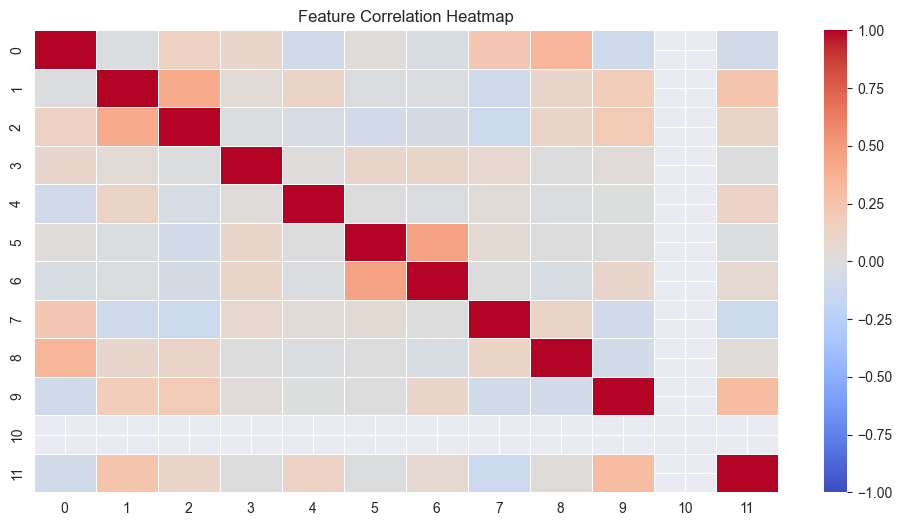

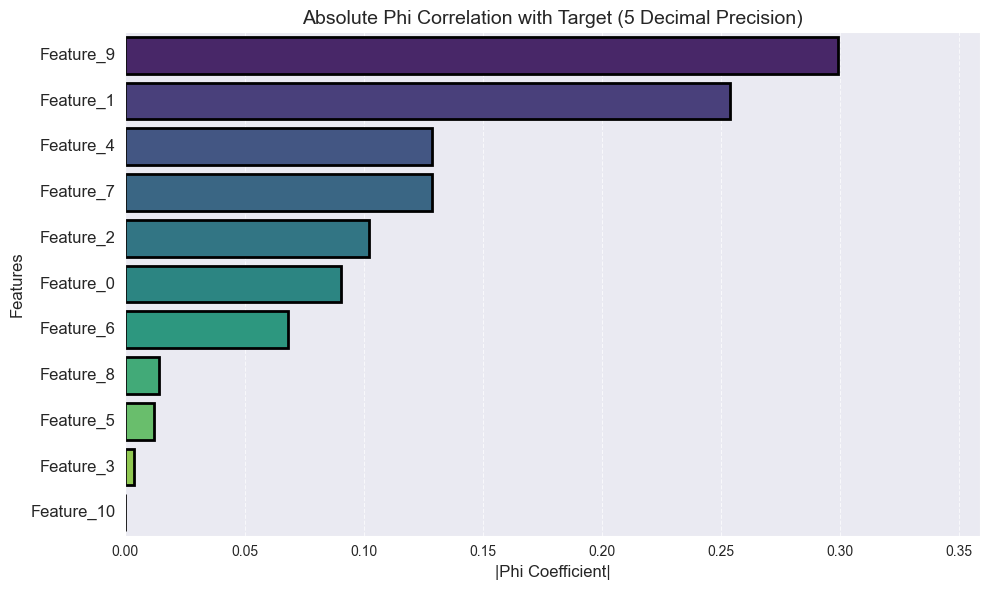

In [4]:
# 特征可视化 ---------------------------------------------
plt.figure(figsize=(12, 6))

# 特征相关性热力图
corr_matrix = pd.DataFrame(list_tensor[:, :]).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1.0, vmax=1.0, fmt=".2f", linewidths=.5)
#sns.heatmap(corr_matrix, annot=False, cmap='coolwarm',fmt=".2f",linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.savefig('heatmap.png')  # 保存热力图
plt.show()

# 合并特征和目标变量
data = pd.DataFrame(list_tensor[:, :-1])
data['target'] = list_tensor[:, -1]  # 将目标变量作为最后一列


# 计算相关系数矩阵（使用Phi系数，适用于二元分类）
def phi_coefficient(col1, col2):
    confusion_matrix = pd.crosstab(col1, col2)
    n = confusion_matrix.sum().sum()
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    return np.sqrt(chi2 / n)


# 计算每个特征与目标变量的Phi系数
phi_values = {}
for col in data.columns[:-1]:
    phi = phi_coefficient(data[col], data['target'])
    phi_values[col] = abs(phi)  # 取绝对值

# 创建排序后的DataFrame时增加小数位数控制
phi_df = (
    pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in phi_values.keys()],  # 强制转换为字符串特征名
        'Abs_Phi_Correlation': np.round(list(phi_values.values()), 5)  # 保留5位小数
    })
    .sort_values('Abs_Phi_Correlation', ascending=False)
    .reset_index(drop=True)
)

# 可视化（加粗柱状图）
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Abs_Phi_Correlation',
    y='Feature',
    hue='Feature',
    data=phi_df,
    palette='viridis',
    legend=False,
    dodge=False,  # 禁止分组偏移
    linewidth=2,  # 边框线宽
    edgecolor='black',  # 添加黑色边框
    saturation=0.8  # 增加颜色饱和度
)

# 调整柱状宽度
plt.gca().set(yticklabels=[])  # 隐藏默认y轴标签
plt.yticks(ticks=range(len(phi_df)),
           labels=phi_df['Feature'],
           fontsize=12,
           va='center')  # 重新设置标签位置

# 通过调整绘图区域控制柱状图宽度
plt.xlim(0, phi_df['Abs_Phi_Correlation'].max() * 1.2)  # 留出右边空白
plt.gcf().subplots_adjust(left=0.3)  # 增加左侧空白区域

# 其他美化设置
plt.title('Absolute Phi Correlation with Target (5 Decimal Precision)', fontsize=14)
plt.xlabel('|Phi Coefficient|', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 尝试如果从9，4，7中选一个

In [5]:
# 设置中文字体（根据系统已安装的字体名称修改）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def plot_feature_probability(feature_column, target_column, feature_name):
    # 提取特征值和目标值（转换为numpy数组）
    feature = list_tensor[:, feature_column].numpy().astype(int)
    target = list_tensor[:, target_column].numpy().astype(int)

    # 筛选特征值为1的样本
    mask = (feature == 1)
    if mask.sum() == 0:  # 避免除以零错误
        print(f"警告：特征 {feature_name} 没有取值为1的样本！")
        return

    # 计算目标为1的概率
    prob = target[mask].mean()

    # 绘制柱状图
    plt.figure(figsize=(8, 4))
    plt.bar([f"{feature_name}=1"], [prob], color='skyblue', edgecolor='black', width=0.5)
    plt.ylim(0, 1)
    plt.ylabel("目标为1的概率", fontsize=12)
    plt.title(f"当 {feature_name}=1 时，目标为1的概率：{prob:.2f}", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

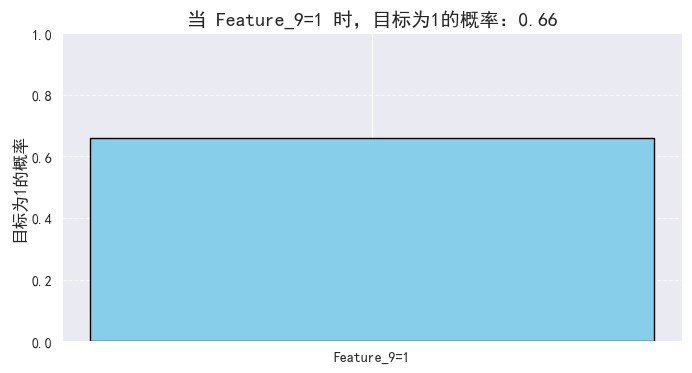

In [6]:
plot_feature_probability(feature_column=9, target_column=-1, feature_name="Feature_9")

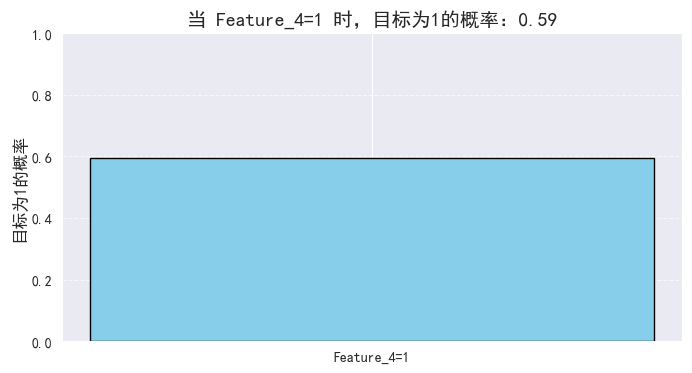

In [7]:
plot_feature_probability(feature_column=4, target_column=-1, feature_name="Feature_4")

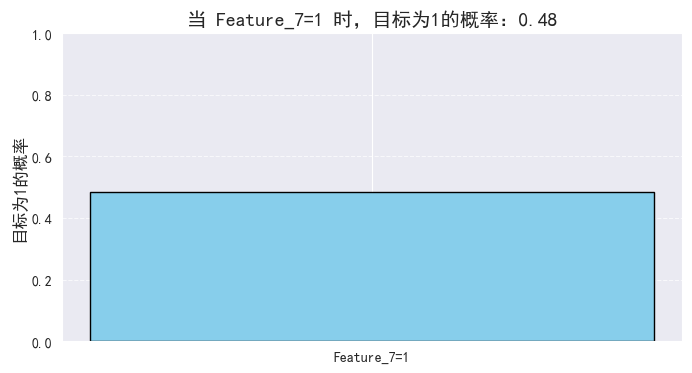

In [8]:
plot_feature_probability(feature_column=7, target_column=-1, feature_name="Feature_7")

综上，这三个有很强的相关性，这三个最好

## 使用逻辑回归+随机梯度下降（SGD），来分类数据，并评估预测准确率

In [15]:
def my_sgd_loss(l, target, lr, batch_size=40, num_epochs=40):
    w = torch.ones(l.shape[1])
    w = torch.nn.init.normal_(w, mean=-1.0, std=1.5)
    b = 0.0
    loss = 0
    for j in range(num_epochs):
        for epoch in range(num_epochs):
            if epoch != j:
                i = epoch * batch_size
                batch_X = l[i:i + batch_size]
                batch_y = target[i:i + batch_size]
                z = torch.matmul(batch_X, w) + b
                sig = 1 / (1 + torch.exp(-z))
                delta_w = torch.matmul(batch_X.T, (sig - batch_y)) / batch_size
                delta_b = torch.sum((sig - batch_y)) / batch_size
                w -= delta_w * lr
                b -= delta_b * lr
        loss += my_loss(j, w, b, l, target, batch_size)
    return loss / num_epochs


def my_dataloader(list_tensor):
    list_tensor = list(list_tensor)
    l = []
    target = []
    for i in list_tensor:
        # 提取三个特征
        features = [i[4], i[7], i[9]]
        l.append(features)
        # 直接添加目标值，而非放入子列表
        target.append(i[-1])
    # 转换时调整target的维度为一维
    return torch.tensor(l), torch.tensor(target).squeeze()


def my_loss(flag, w, b, l, target, batch_size):
    i = flag * batch_size
    test_data = l[i:i + batch_size]
    # 移除转置操作 .T
    p = torch.matmul(test_data, w) + b  # 正确维度计算
    p = torch.where(p >= 0.5, 1.0, 0.0)  # 调整阈值判断
    correct = (p == target[i:i + batch_size]).sum().item()
    loss = correct / len(test_data)
    return loss


l, target = my_dataloader(list_tensor)
loss = my_sgd_loss(l, target, 0.01)
print(f'最后综合的平均损失是{loss}')

最后综合的平均损失是0.48977564102564103


## Pytorch训练二分类神经网络，采用伪“交叉验证”方式评估准确率

In [11]:

net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3, out_features=8),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(in_features=8, out_features=1),
)


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=-1.0, std=0.05)


net.apply(init_weights)
batch_size, lr, num_epochs = 40, 0.01, 40
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
loss = nn.BCEWithLogitsLoss()


def train_evaluate(l, batch_size=40, num_epochs=40):
    val_loss = 0
    correct = 0
    total = 0
    val_accuracy = 0
    for j in range(num_epochs):
        net.train()  # 训练模式
        for i in range(num_epochs):
            if j != i:
                batch_x = l[i * batch_size:(i + 1) * batch_size]
                batch_y = target[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                my_loss = loss(net(batch_x).squeeze(), batch_y)
                my_loss.backward()
                optimizer.step()
                # 预测时，模型输出概率值
        # 每个epoch结束后进行评估（示例中使用当前epoch最后一个batch）
        net.eval()  # 评估模式
        with torch.no_grad():
            batch_x = l[j * batch_size:(j + 1) * batch_size]
            batch_y = target[j * batch_size:(j + 1) * batch_size]
            # 示例：评估最后一个batch，实际应用中应使用验证集
            eval_batch_x = l[j * batch_size:(j + 1) * batch_size]
            eval_logits = net(eval_batch_x).squeeze()  # 压缩维度
            # 计算验证损失
            val_loss += loss(eval_logits, batch_y).item() * len(batch_x)

            probabilities = torch.sigmoid(eval_logits)  # 转换为概率
            predictions = (probabilities >= 0.5).float()
            correct += (predictions == batch_y).sum().item()
            total += len(batch_y)

            # ACC如下
            val_accuracy += correct / total
    avg_val_accuracy = val_accuracy / num_epochs
    print(f'每折平均准确率为{avg_val_accuracy:.5f}')
    avg_loss = val_loss / len(l)
    print(f'最终的损失为{avg_loss:.5f}')


# 调用
l, target = my_dataloader(list_tensor)
init_weights(net)
train_evaluate(l, batch_size=40, num_epochs=40)

每折平均准确率为0.56422
最终的损失为0.65475
